# 2019 L-band cross-correlation analysis

This notebook contains the code for performing cross-correlation analysis for MeerKLASS 2019 L-band data x WiggleZ. 

The 21cm map data is publically available at https://meerklass.org/data.html 

The detailed description of each data analysis step can be found in https://meer21cm.readthedocs.io/en/latest/cookbook/2021_Lband_gama_cross.html 

In [1]:
from meer21cm import PowerSpectrum
import matplotlib.pyplot as plt
import numpy as np
from meer21cm.util import pca_clean
from meer21cm.telescope import dish_beam_sigma
from meer21cm.util import center_to_edges
from meer21cm.plot import plot_map, plot_eigenspectrum
from meer21cm.inference import SamplerEmcee, extract_model_fitting_inputs
from meer21cm.transfer import TransferFunction
from meer21cm.grid import shot_noise_correction_from_gridding



/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [2]:
file_dir = '/Users/zhaotingchen/Desktop/work/meer21cm/misc/2019/'
pickle_file = file_dir+'MK_2019_maps.pkl'
gal_file = file_dir+'reg11data.dat'

ps = PowerSpectrum(
    pickle_file=pickle_file,
    #gal_file=gal_file,
    beam_model='gaussian',
    beam_type='isotropic',
    band='L',
    survey='meerklass_2019',
)
# read in map_file
ps.read_from_pickle()
# read in galaxy positions
galcat = np.genfromtxt(gal_file, skip_header=1)
ra_g,dec_g,z_g = galcat[:,0],galcat[:,1],galcat[:,2]
ps._ra_gal = ra_g
ps._dec_gal = dec_g
ps._z_gal = z_g
D_dish = 13.5 # Dish-diameter [metres]
sigma_ch = dish_beam_sigma(D_dish,ps.nu,)
ps.sigma_beam_ch = sigma_ch


filtering map los


In [3]:
# this is just for plotting the contour below
temp = PowerSpectrum(
    pickle_file=pickle_file,
    #gal_file=gal_file,
    beam_model='gaussian',
    beam_type='isotropic',
    band='L',
    survey='meerklass_2019',
)
temp.read_from_pickle()
temp.W_HI = np.ones_like(temp.W_HI)
temp.ra_range = np.array([153,172])
temp.dec_range = np.array([0.5,6.6])
temp.trim_map_to_range()

filtering map los


NameError: name 'temp' is not defined

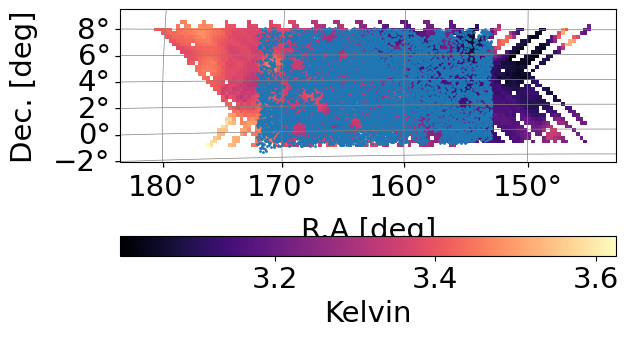

In [3]:
plt.rcParams.update({'font.size': 21})
plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
ax = plt.gca()
ax.scatter(
    ps.ra_gal,
    ps.dec_gal,
    transform=ax.get_transform('world'),
    s=1,
    alpha=1,
)
ax.contour(temp.W_HI[:,:,0].T,level=[0.5],colors='black')
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,cbar_label='count')

In [4]:
ps.ra_range = np.array([153,172])
ps.dec_range = np.array([0.5,6.6])
ps.trim_map_to_range()
ps.trim_gal_to_range()

array([False, False, False, ..., False, False, False])

In [5]:
MKmap_orig = ps.data.copy()

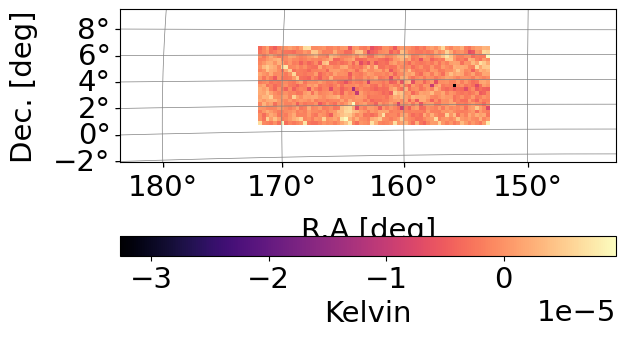

In [6]:
N_fg = 10
MKmap_clean, A_mat = pca_clean(MKmap_orig,N_fg,weights=ps.w_HI,mean_center=True, return_A=True)
plot_map(MKmap_clean,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')


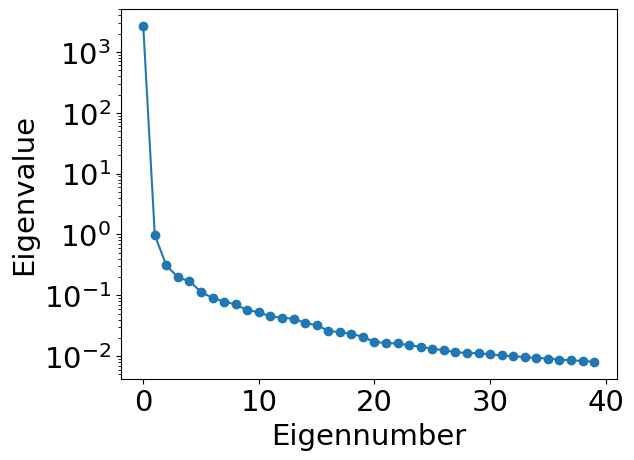

<Figure size 640x480 with 0 Axes>

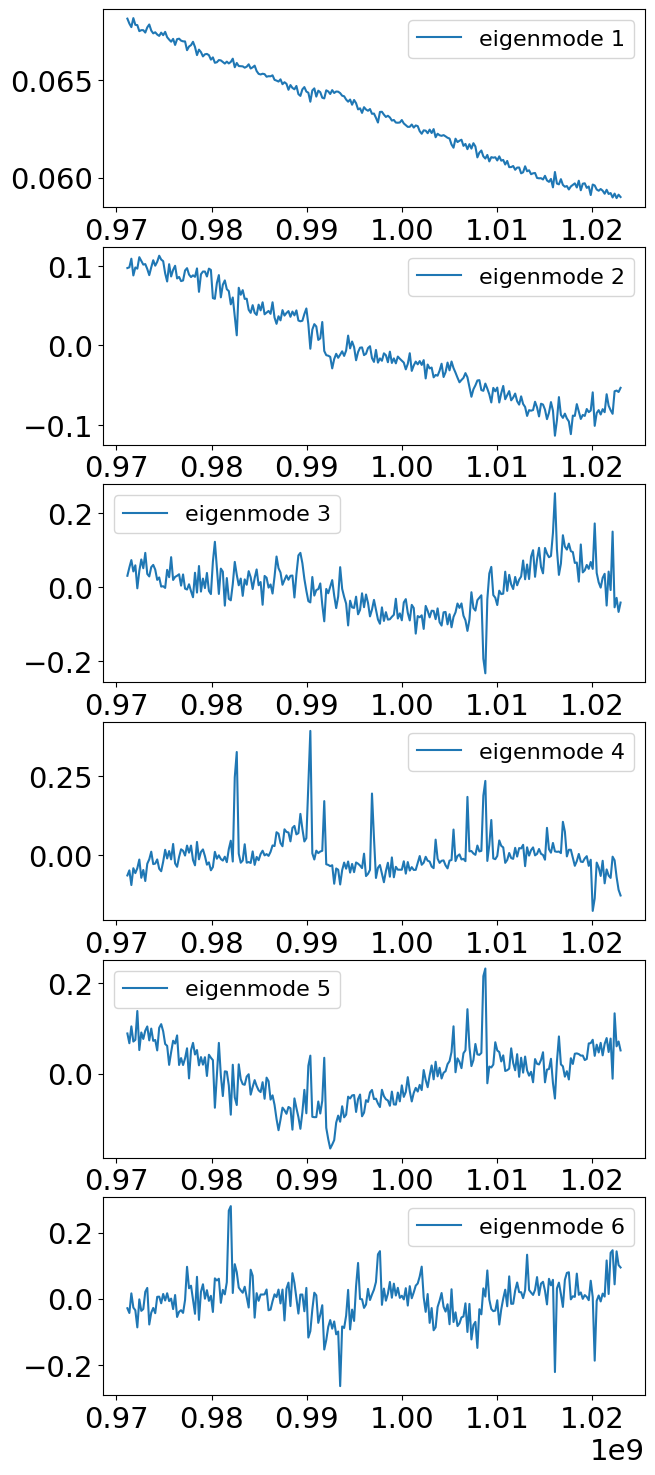

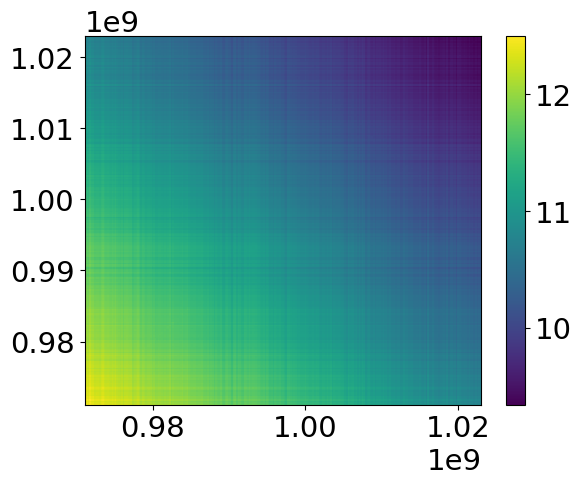

In [9]:
nu_edges = center_to_edges(ps.nu)
cov_map,eignumb,eigenval,V = pca_clean(MKmap_orig,N_fg=1,weights=ps.W_HI,return_analysis=True,mean_center=True) # weights included in covariance calculation
plot_eigenspectrum(np.array([eigenval]))
plt.figure()
Num = 6
chart = 100*Num + 11
plt.figure(figsize=(7,3*Num))
for i in range(Num):
    plt.subplot(chart + i)
    plt.plot(ps.nu,V[:,i],label='eigenmode %s'%(i+1))
    #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
    plt.legend(fontsize=16)
plt.figure()
plt.pcolormesh(nu_edges,nu_edges,cov_map)
plt.colorbar()

In [10]:
ps.data = MKmap_clean
# specify some scaling factor
ps.downres_factor_transverse = 1.2
ps.downres_factor_radial = 10
#ps.box_buffkick = [-10,-30,-20]
ps.box_buffkick = [20,20,-15]
ps.num_particle_per_pixel = 1
ps.grid_scheme = 'nnb'
ps.get_enclosing_box() # get the minimum enclosing box for the survey lightcone
ps.box_len, ps.box_resol


(array([230.91364218, 629.00778801, 253.28714617]),
 array([10.99588772, 10.66114895, 10.13148585]))

In [11]:
hi_map_rg,hi_weights_rg,pixel_counts_hi_rg =  ps.grid_data_to_field()

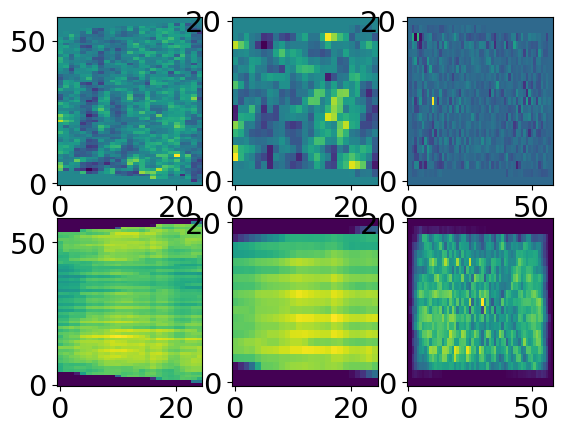

In [12]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    axes[0,i].imshow(
        hi_map_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    axes[1,i].imshow(
        ps.counts_in_box.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

In [13]:
gal_map_rg,gal_weights_rg,pixel_counts_gal_rg =  ps.grid_gal_to_field()


In [14]:
ps.field_1 = hi_map_rg.copy()
ps.weights_1 = ps.counts_in_box.astype('float')
#ps.weights_1 = (pixel_counts_hi_rg>0).astype('float')
ps.field_2 = gal_map_rg
ps.weights_2 = (ps.counts_in_box>0).astype('float')
ps.mean_center_1 = False # the field is already mean centered
ps.mean_center_2 = True # galaxy count is not
ps.unitless_1 = False # HI field is in temperature unit, does not need to 1/\bar{\pho}
ps.unitless_2 = True # galaxy count to overdensity needs 1/\bar{n}
ps.sampling_resol = np.array([
        ps.pix_resol_in_mpc,
        ps.pix_resol_in_mpc,
        ps.los_resol_in_mpc,
])
ps.compensate = True
ps.include_sky_sampling = [True, False]
ps.apply_taper_to_field(1, axis=[2,]) # apply taper to field 1(HI), taper in all directions
ps.apply_taper_to_field(2, axis=[2,]) # apply taper to field 1(HI), taper in all directions



In [15]:
nkbin = 11
# in h/Mpc
kmin,kmax = 0.07,0.3
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
# in Mpc-1
kbins *= ps.h
# in h/Mpc
kcuts = [0.02,0.02,0.25,0.25] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)
# in Mpc-1
kcuts = np.array(kcuts) * ps.h
k_sel = np.ones_like(ps.k_mode)
k_sel[0] = 0.0
k_sel[:,0,:] = 0.0
k_sel[:,:,0] = 0.0
k_sel *= (
    (np.abs(ps.k_perp<=kcuts[2]) * np.abs(ps.k_perp>kcuts[0]))[:,:,None] *
    (np.abs(ps.k_para<=kcuts[3]) * np.abs(ps.k_para>kcuts[1]))[None,None]
).astype('float')
ps.k1dbins = kbins


In [16]:
ps.tracer_bias_2 = 1.3
ps.tracer_bias_1 = 1.5
ps.omega_hi = 5e-4
ps.mean_amp_1 = 'average_hi_temp'

In [17]:
pdata_1d_cross,keff_c,nmodes_c = ps.get_1d_power(ps.cross_power_3d,k1dweights=k_sel)
pdata_1d_gg,keff_gg,nmodes_gg = ps.get_1d_power(ps.auto_power_3d_2,k1dweights=k_sel)
pdata_1d_hi,keff_hi,nmodes_hi = ps.get_1d_power(ps.auto_power_3d_1,k1dweights=k_sel)
pmod_1d_gg,keff_gg,nmodes_gg = ps.get_1d_power(ps.auto_power_tracer_2_model,k1dweights=k_sel)
# shot noise for galaxy auto-power
psn = ps.survey_volume/ps.ra_gal.size * shot_noise_correction_from_gridding(ps.box_ndim,ps.grid_scheme)
psn_1d_gg,_,_ = ps.get_1d_power(psn,k1dweights=k_sel)

Text(0.5, 1.0, 'Galaxy auto-power spectrum')

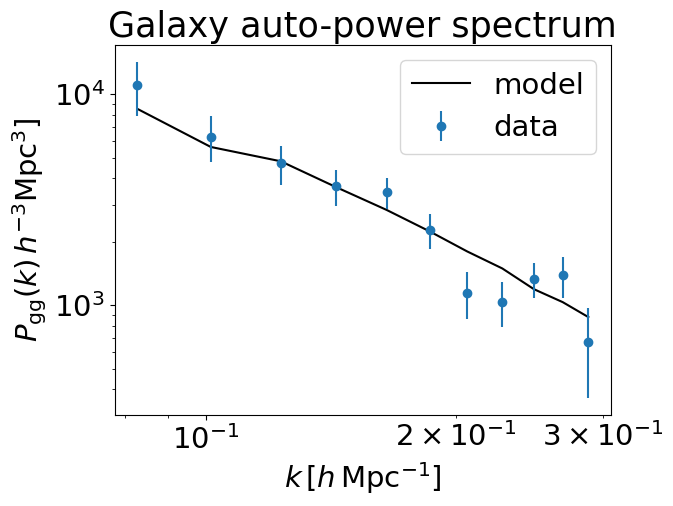

In [18]:
# a naive error bar 
perror_1d_gg = (pdata_1d_gg)/np.sqrt(nmodes_gg)

plt.plot(keff_gg/ps.h,pmod_1d_gg*ps.h**3,label='model',color='black')
plt.errorbar(keff_gg/ps.h,(pdata_1d_gg-psn_1d_gg)*ps.h**3,
             yerr=perror_1d_gg*ps.h**3,
             ls='none',
             marker='o',
             label='data')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm gg}(k)\,h^{-3}{\rm Mpc}^3]$')
plt.title('Galaxy auto-power spectrum')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

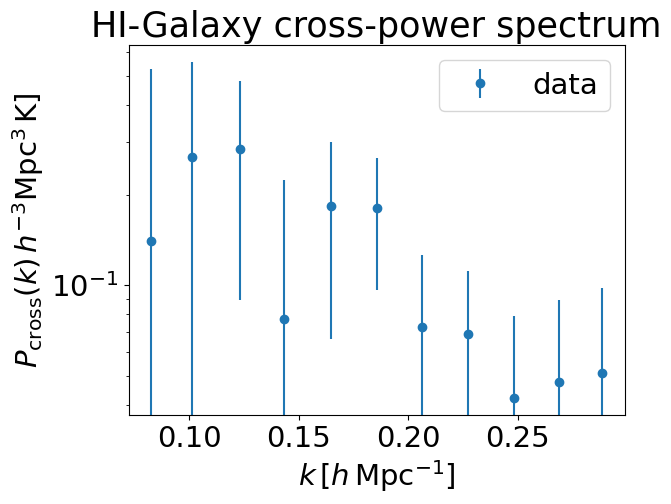

In [19]:
# a naive error bar 
perror_1d_c = np.sqrt((pdata_1d_cross**2 + pdata_1d_hi * pdata_1d_gg)/2)/np.sqrt(nmodes_c)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff_c/ps.h,(pdata_1d_cross)*ps.h**3,
             yerr=perror_1d_c*ps.h**3,
             ls='none',
             marker='o',
             label='data')

#plt.xscale('log')
#plt.yscale('symlog',linthresh=1e-1)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

In [20]:
ps.kperpbins = np.linspace(0, 0.3, 11)
ps.kparabins = np.linspace(0, 0.3, 11)

In [21]:
pcross_cy,_ = ps.get_cy_power(ps.cross_power_3d)

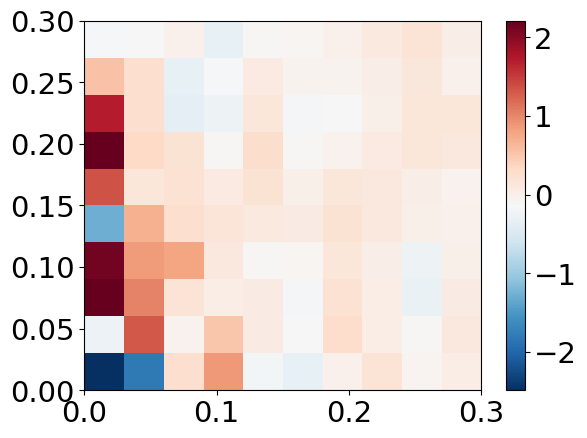

In [22]:
plt.pcolormesh(ps.kperpbins,ps.kparabins,(pcross_cy.T),cmap='RdBu_r')
plt.colorbar()

In [23]:
# pass the ps specficiations as well as some simulation settings
tf = TransferFunction(
    ps, N_fg=N_fg, 
    # generate mock data on a high-resolution grid, then to average it to sky map for injection
    highres_sim=2, upres_transverse=2, upres_radial=2,
    uncleaned_data=MKmap_orig, # inject into the map data to reperform PCA
    num_process=8, # number of available cpus to run parallel calculation
    pca_map_weights=ps.w_HI.astype('float'),
)
# run a null test as well, 100 realisations
null_test_arr = tf.run(range(100), type='null', return_power_3d=False)
# run tf calculation
results_arr = tf.run(range(100), type='cross', return_power_3d=False, return_power_1d=True)

/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/mini

In [28]:
# organise the results of 100 realisations
tf_1d_arr = []
pnull_1d_arr = []
pmock_1d_cross_arr = []
pmock_1d_cross_cleaned_arr = []
for i in range(len(results_arr)):
    tf_1d_arr.append(results_arr[i][0])
    pnull_1d_arr.append(null_test_arr[i][0])
    pmock_1d_cross_arr.append(results_arr[i][1])
    pmock_1d_cross_cleaned_arr.append(results_arr[i][2])

tf_1d_arr = np.array(tf_1d_arr)
pnull_1d_arr = np.array(pnull_1d_arr)
pmock_1d_cross_arr = np.array(pmock_1d_cross_arr)
pmock_1d_cross_cleaned_arr = np.array(pmock_1d_cross_cleaned_arr)

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

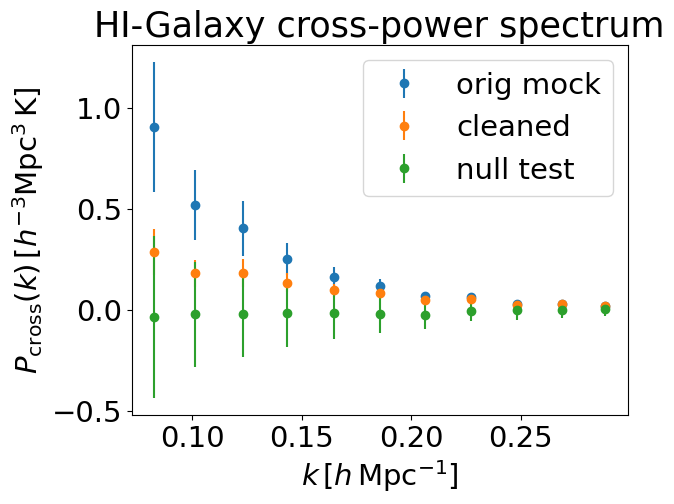

In [29]:
plt.errorbar(keff_c/ps.h,(pmock_1d_cross_arr).mean(0)*ps.h**3,
             yerr=pmock_1d_cross_arr.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='orig mock')
plt.errorbar(keff_c/ps.h,(pmock_1d_cross_cleaned_arr).mean(0)*ps.h**3,
             yerr=pmock_1d_cross_cleaned_arr.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='cleaned')
plt.errorbar(keff_c/ps.h,(pnull_1d_arr).mean(0)*ps.h**3,
             yerr=pnull_1d_arr.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='null test')
#plt.xscale('log')
#plt.yscale('symlog',linthresh=1e-2)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,[h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

In [30]:
tf_1d_mean = np.mean(tf_1d_arr, axis=0)
# a naive error bar
perror_1d_tf = np.sqrt((pdata_1d_cross**2/tf_1d_mean**2 + pdata_1d_hi * pdata_1d_gg/tf_1d_mean)/2)/np.sqrt(nmodes_c-1)
# correlation matrix
corr_mat_tf = np.corrcoef((1/tf_1d_arr).T)
cov_mat_tf = corr_mat_tf * perror_1d_tf[:,None] * perror_1d_tf[None,:]

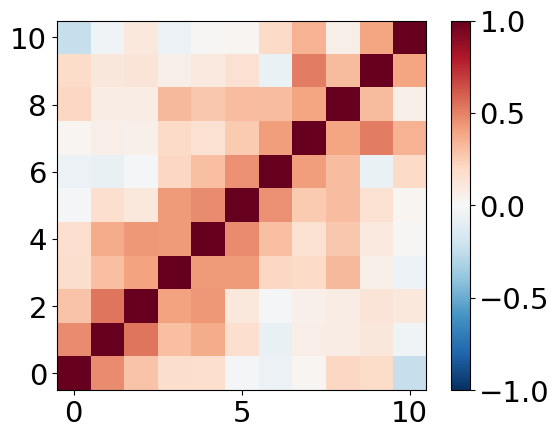

In [31]:
plt.imshow(corr_mat_tf, vmin=-1, vmax=1,cmap='RdBu_r', origin='lower')
plt.colorbar()

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

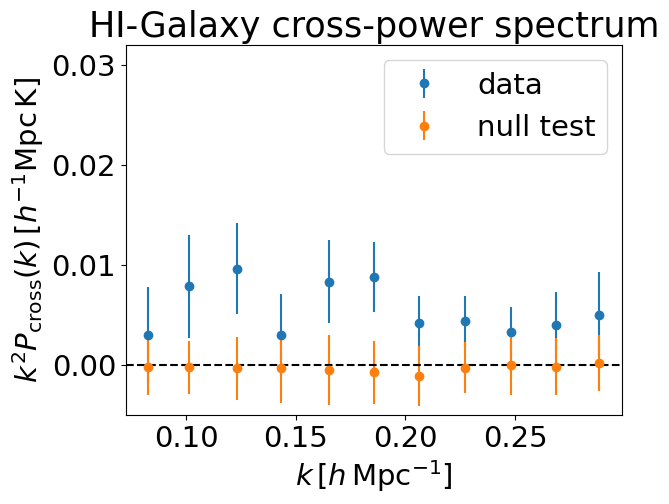

In [32]:
k_factor = keff_c**2 / ps.h**2
#plt.plot(keff_c/ps.h, pmod_1d_c*ps.h**3 * k_factor)
plt.errorbar(keff_c/ps.h,(pdata_1d_cross/tf_1d_mean)*ps.h**3 * k_factor,
             yerr= (perror_1d_tf)*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')

plt.errorbar(keff_c/ps.h,(pnull_1d_arr).mean(0)*ps.h**3 * k_factor,
             yerr=pnull_1d_arr.std(0)*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='null test')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-0.005,0.032)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2 P_{\rm cross}(k)\,[h^{-1}{\rm Mpc\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

In [33]:
pmod_1d_c,_,_ = ps.get_1d_power(ps.cross_power_tracer_model,k1dweights=k_sel)

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

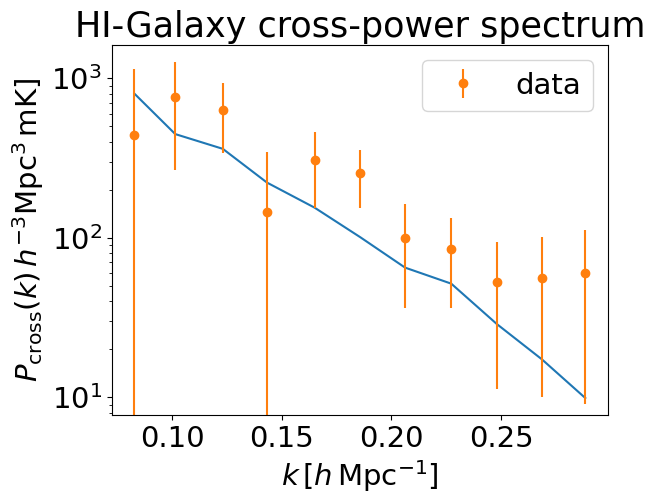

In [34]:
# check the power spectrum in volume unit:
k_factor = 1e3
plt.plot(keff_c/ps.h, pmod_1d_c*ps.h**3 * k_factor)
plt.errorbar(keff_c/ps.h,(pdata_1d_cross/tf_1d_mean)*ps.h**3 * k_factor,
             yerr= perror_1d_tf*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')
plt.yscale('log')
#plt.ylim(1e1,5e3)
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,mK}]$')
plt.title('HI-Galaxy cross-power spectrum')

In [35]:
data_vector = (pdata_1d_cross/tf_1d_mean)
data_covariance = cov_mat_tf
np.sqrt(data_vector @ np.linalg.inv(data_covariance) @ data_vector)

np.float64(3.653933896511823)

In [36]:
data_vector = (pdata_1d_cross/tf_1d_mean)
data_covariance = cov_mat_tf
# fit two parameters, overall HI density and beam size
# init position
ps.omega_hi = 5e-4
ps.sigma_beam_ch = ps.sigma_beam_ch.mean()
# tell sampler which parameters to vary
varied_params = ['omega_hi', 'sigma_beam_ch']
# specify priors
params_priors = [
    ('uniform', 1e-4, 2e-3), # flat prior, lower, upper
    # gaussian prior, mean, sigma
    ('gaussian', ps.sigma_beam_ch.mean(), 0.1), # beam model should be close to truth since it is a measurement

]
# here we use emcee-sampler
sampler = SamplerEmcee(
    extract_model_fitting_inputs(ps), 
    data_vector, 
    data_covariance, 
    params_name=varied_params, 
    params_prior=params_priors,
    observables=['cross'], # only fit cross power
    save=True,
    save_filename='fitting2.h5',
    nwalkers=4,
    nsteps=200,
    nthreads=8,
)

In [37]:
init_pos = np.array([5e-4, ps.sigma_beam_ch.mean()])
start_coord = (
    1 + np.random.uniform(-1e-2, 1e-2, size=(sampler.nwalkers, sampler.ndim))
) * init_pos[None, :]

In [39]:
# resume = True if you are starting from a previous run
sampler.run(resume=False, progress=True, start_coord=start_coord)

/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion
  0%|          | 0/200 [

In [44]:
# posterior
points = sampler.get_points().reshape((-1,2))
points[:,0] = points[:,0]*1e3

In [45]:
log_prob = sampler.get_log_prob()
best_fit = sampler.get_points().reshape((-1,2))[np.argmax(sampler.get_log_prob())]

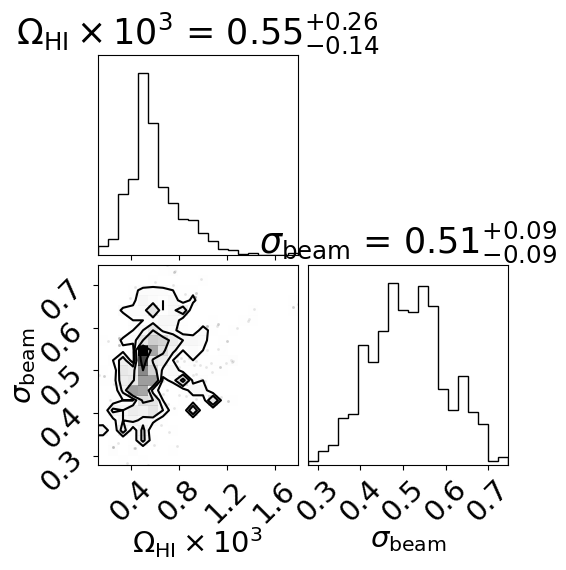

In [46]:
import corner
corner.corner(
    points,
    labels=[r'$\Omega_{\rm HI}\times 10^3$', r'$\sigma_{\rm beam}$'],
    show_titles=True,
);

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

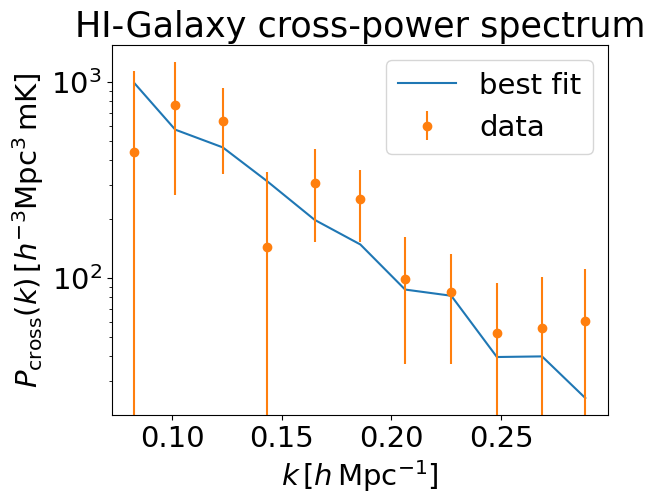

In [43]:
# a naive error bar 
#k_factor = keff_c**2 / ps.h**2
k_factor = 1e3
plt.plot(keff_c/ps.h, sampler.get_model_vector(best_fit)[0]*ps.h**3 * k_factor,label='best fit',)
plt.errorbar(keff_c/ps.h,(pdata_1d_cross/tf_1d_mean)*ps.h**3 * k_factor,
             yerr= perror_1d_tf*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')
plt.yscale('log')
#plt.ylim(1e1,9e3)
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,[h^{-3}{\rm Mpc^3\,mK}]$')
plt.title('HI-Galaxy cross-power spectrum')